This tutorial recreates the Rich Club analysis from Tow

# Imports

In [2]:
!git clone https://github.com/ChristianPritz/unito_connectomics_i
%cd unito_connectomics_i
import os
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import importlib
#import connectomics_functions   
#importlib.reload(connectomics_functions)
#from connectomics_functions import plot_adjacency_matrix,metric_set, randomize_graph, rich_club, plot_rich_club, plot_network, plot_weight_distribution,visualize_nx_graph
from connectomics_functions import *

Imports are sucessufl #######################################


# Let us see how networkX encodes a graph

* create and example network
* plot the adjacency matrix
* directed vs. undirected

##########################################
Weights look like this as a dataframe
   Neuron 1 Neuron 2  Weight
0         A        B       3
1         B        A       1
2         B        C       2
3         C        B       1
4         D        C       3
5         D        B       1
6         C        E       1
7         E        C       1
8         D        F       1
9         G        E       1
10        G        F       1
11        F        E       2


Graph displayed inline, file saved as /home/wormulon/Documents/teaching/compuational neuroscience/connectomics I/unito_connectomics_i/nx_graph.html


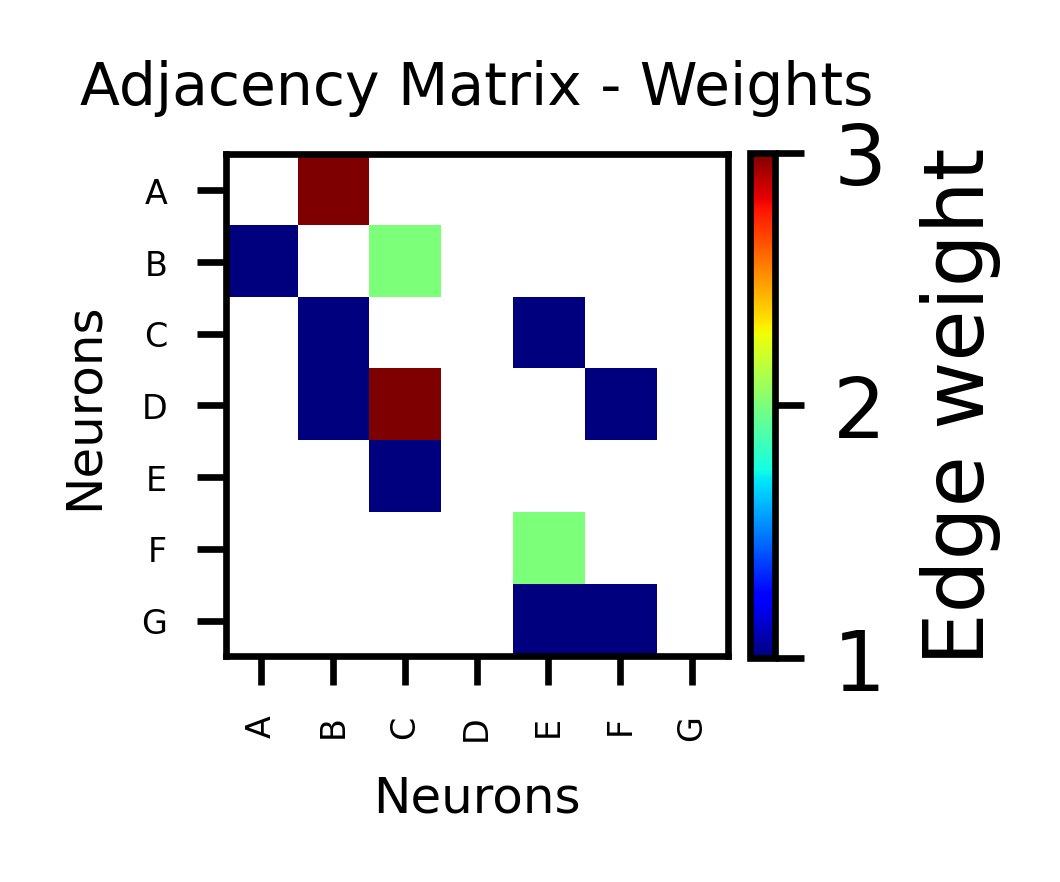

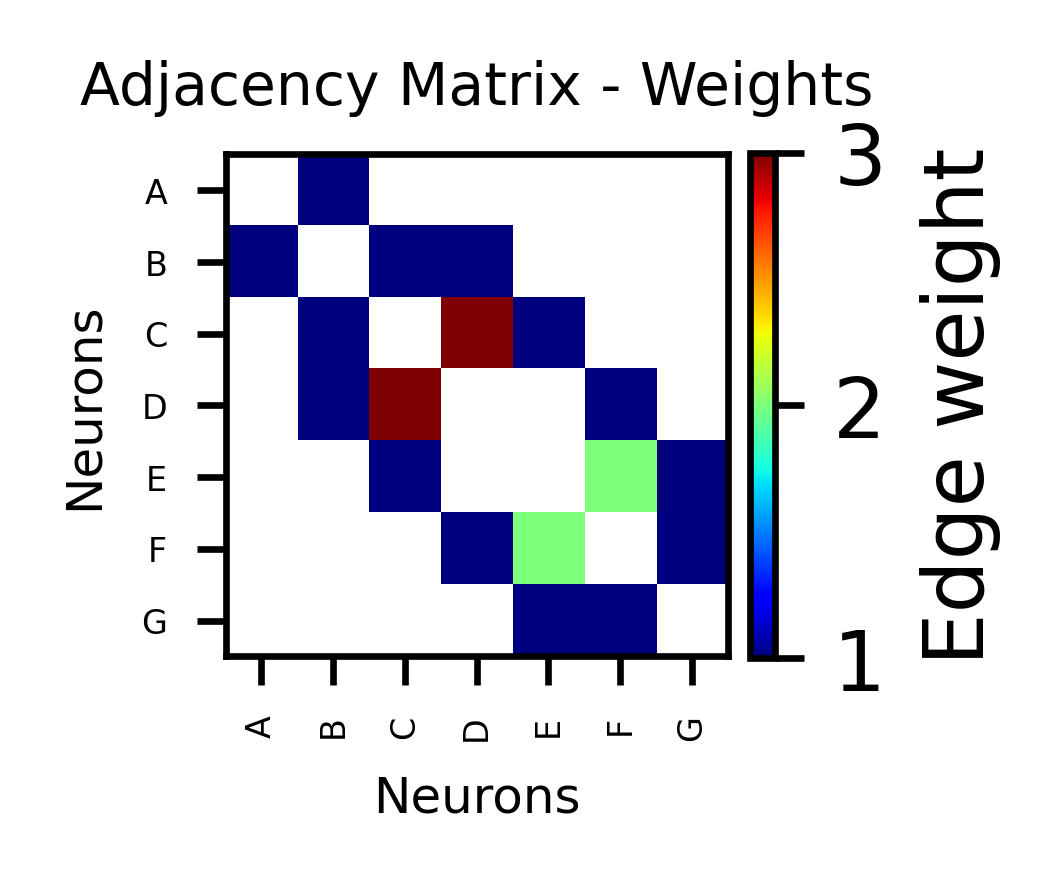

In [60]:
# define a small network, defining the edges 

w_list = [{'Neuron 1':'A','Neuron 2':'B','Weight':3},
          {'Neuron 1':'B','Neuron 2':'A','Weight':1},
          {'Neuron 1':'B','Neuron 2':'C','Weight':2},
          {'Neuron 1':'C','Neuron 2':'B','Weight':1},
          {'Neuron 1':'D','Neuron 2':'C','Weight':3},
          {'Neuron 1':'D','Neuron 2':'B','Weight':1},
          {'Neuron 1':'C','Neuron 2':'E','Weight':1},
          {'Neuron 1':'E','Neuron 2':'C','Weight':1},
          {'Neuron 1':'D','Neuron 2':'F','Weight':1},
          {'Neuron 1':'G','Neuron 2':'E','Weight':1},
          {'Neuron 1':'G','Neuron 2':'F','Weight':1},
          {'Neuron 1':'F','Neuron 2':'E','Weight':2}]

# reating it into a pandas dataframe 
w_df = pd.DataFrame(w_list)

print('##########################################')
print('Weights look like this as a dataframe')
print(w_df)

#instantiating the NX graph
G_dir_demo = nx.from_pandas_edgelist(
    w_df,
    source='Neuron 1',
    target='Neuron 2',
    edge_attr='Weight',
    create_using=nx.DiGraph()
)

#instantiating a directed graph
G_dir_demo = nx.from_pandas_edgelist(
    w_df,
    source='Neuron 1',
    target='Neuron 2',
    edge_attr='Weight',
    create_using=nx.DiGraph()
)
#instantiating an undirected graph
G_undir_demo = nx.from_pandas_edgelist(
    w_df,
    source='Neuron 1',
    target='Neuron 2',
    edge_attr='Weight',
    create_using=nx.Graph()
)

visualize_graph(G_dir_demo,node_size=100, edge_width_factor=10, label_font_size=72)
#plot_network(G_dir_demo, node_size_factor=30, edge_width_factor=2, cmap="viridis", figsize=(5,5))


plot_adjacency_matrix(G_dir_demo,sort_nodes=False,figsize=(2,2))
plot_adjacency_matrix(G_undir_demo,sort_nodes=False,figsize=(2,2))






# Let us load the C.elegans connectome

In [21]:
# ======== LOAD DATA ==========================================================
edge_list_path = "./data/NeuronConnect.csv"
raw_data = pd.read_csv(edge_list_path)
raw_data = raw_data.rename(columns={'Nbr': 'weight'})

#raw_data = raw_data.drop(np.where(raw_data.Type == "NMJ")[0])

# instantiating a directed graph
G_dir = nx.from_pandas_edgelist(
    raw_data,
    source='Neuron 1',
    target='Neuron 2',
    edge_attr='weight',
    create_using=nx.DiGraph()
)

#the edges are stored in adjacency dict
print('#############################################################')
print("The adjacency matrix has", str(len(G_dir._adj)), "entries")
print("Individual edges per neurons in this dict look like the \n this (AWCR as example):")
for nbr, datadict in G_dir.adj['AWCR'].items():
    print(nbr,datadict)


#nodes are stored in a the nodes property. 
print('#############################################################')
nodes = list(G_dir.nodes)[:10]
print("Nodes are stored in the 'node' property")
print(f"{nodes} ... and many more")

#############################################################
The adjacency matrix has 283 entries
Individual edges per neurons in this dict look like the 
 this (AWCR as example):
ADLR {'weight': 3}
AIAL {'weight': 1}
AIAR {'weight': 1}
AIBR {'weight': 4}
AIYL {'weight': 3}
AIYR {'weight': 6}
ASEL {'weight': 1}
ASER {'weight': 1}
ASGR {'weight': 1}
ASIL {'weight': 1}
ASIR {'weight': 1}
AWCL {'weight': 4}
#############################################################
Nodes are stored in the 'node' property
['ADAR', 'ADAL', 'ADFL', 'ASHL', 'AVDR', 'PVQL', 'ADEL', 'AIAL', 'AIBL', 'AIBR'] ... and many more


### Let us see the adjacency matrix
#### Note that the adjacency matrix is sparse! 

ADLR {'weight': 3}
AIAL {'weight': 1}
AIAR {'weight': 1}
AIBR {'weight': 4}
AIYL {'weight': 3}
AIYR {'weight': 6}
ASEL {'weight': 1}
ASER {'weight': 1}
ASGR {'weight': 1}
ASIL {'weight': 1}
ASIR {'weight': 1}
AWCL {'weight': 4}


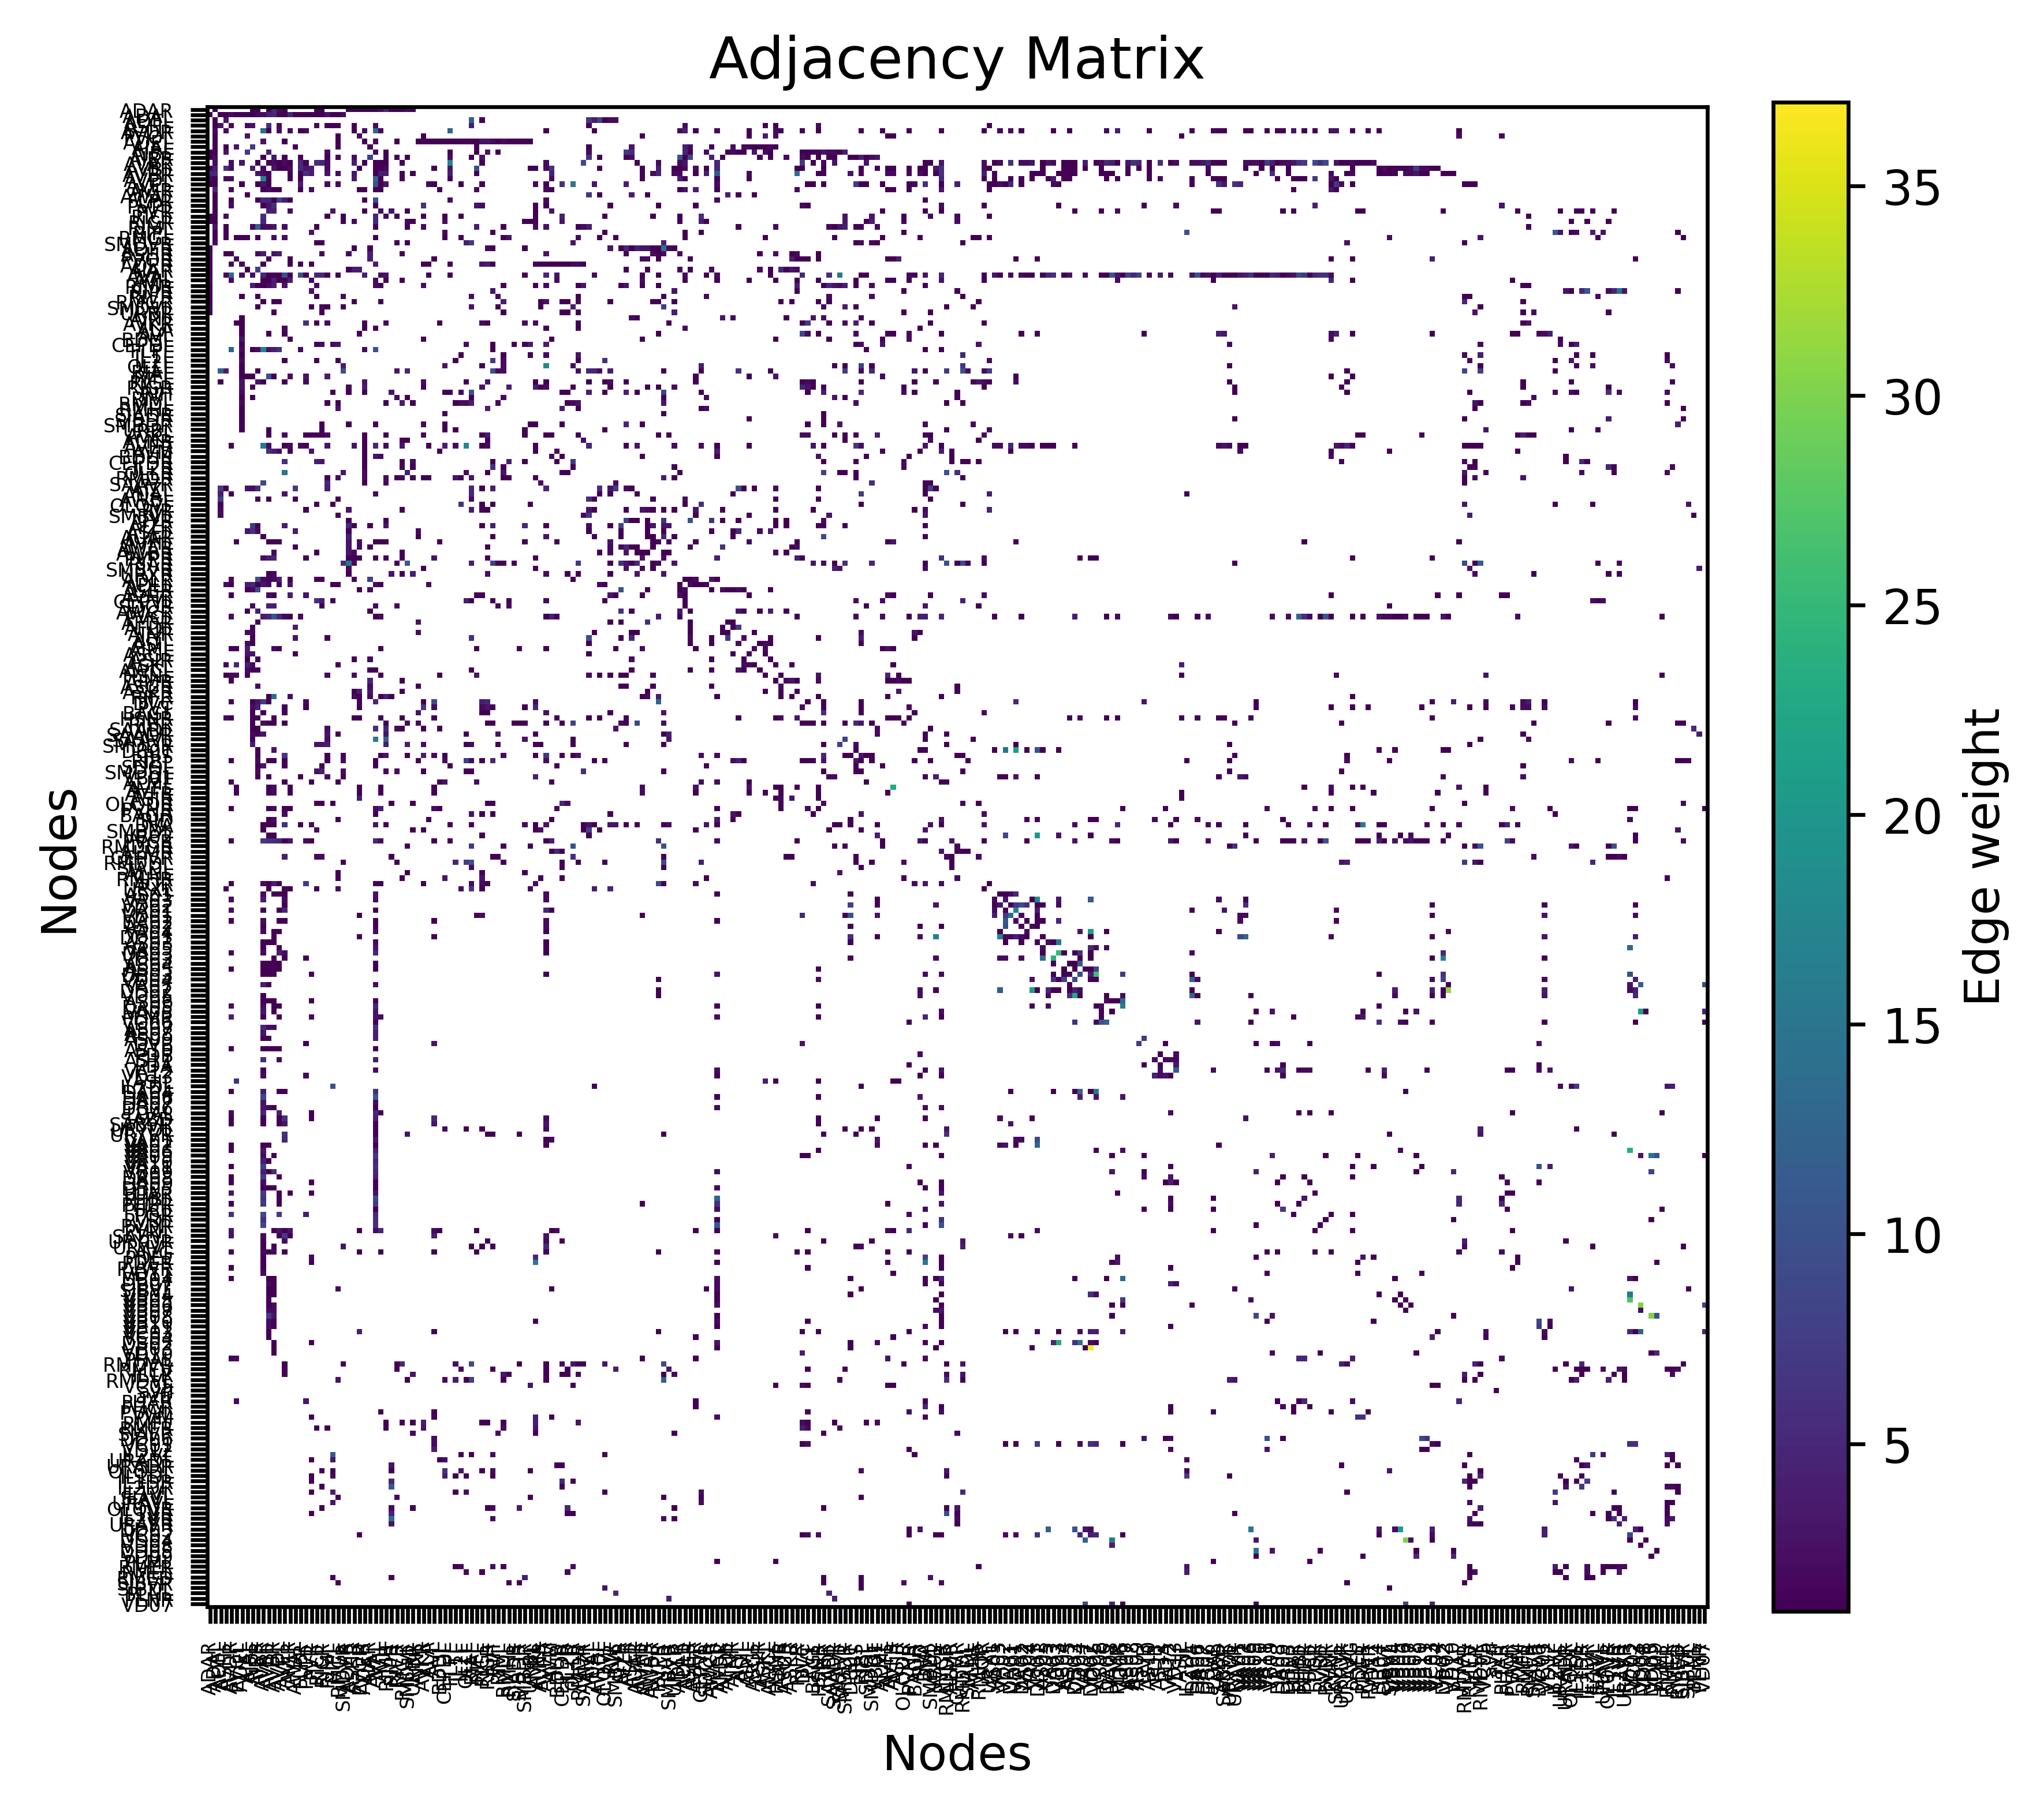

In [24]:
#plotting a adjacency matrix 
plot_adjacency_matrix(G_dir,cmap='jet',sort_nodes=False,figsize=(6,6))

#the undirected graph would look like this: 
G_und = G_dir.to_undirected()
plot_adjacency_matrix(G_und,cmap='jet',sort_nodes=False,figsize=(6,6))

plot_weight_distribution(G_dir, bins=50, fit_powerlaw=False)




# Let's compute the rich club

* we determine if a rich club candidate neuron is signficiant if: rc[real] > rc[rand] + stdev(rc[rand])
   

Rich-club threshold degree: 41
Number of neurons in rich club: 12
Rich-club neurons: ['AVDR', 'AVAR', 'AVBL', 'AVBR', 'AVDL', 'AVEL', 'AVAL', 'AVER', 'PVCL', 'DVA', 'PVCR', 'NMJ']


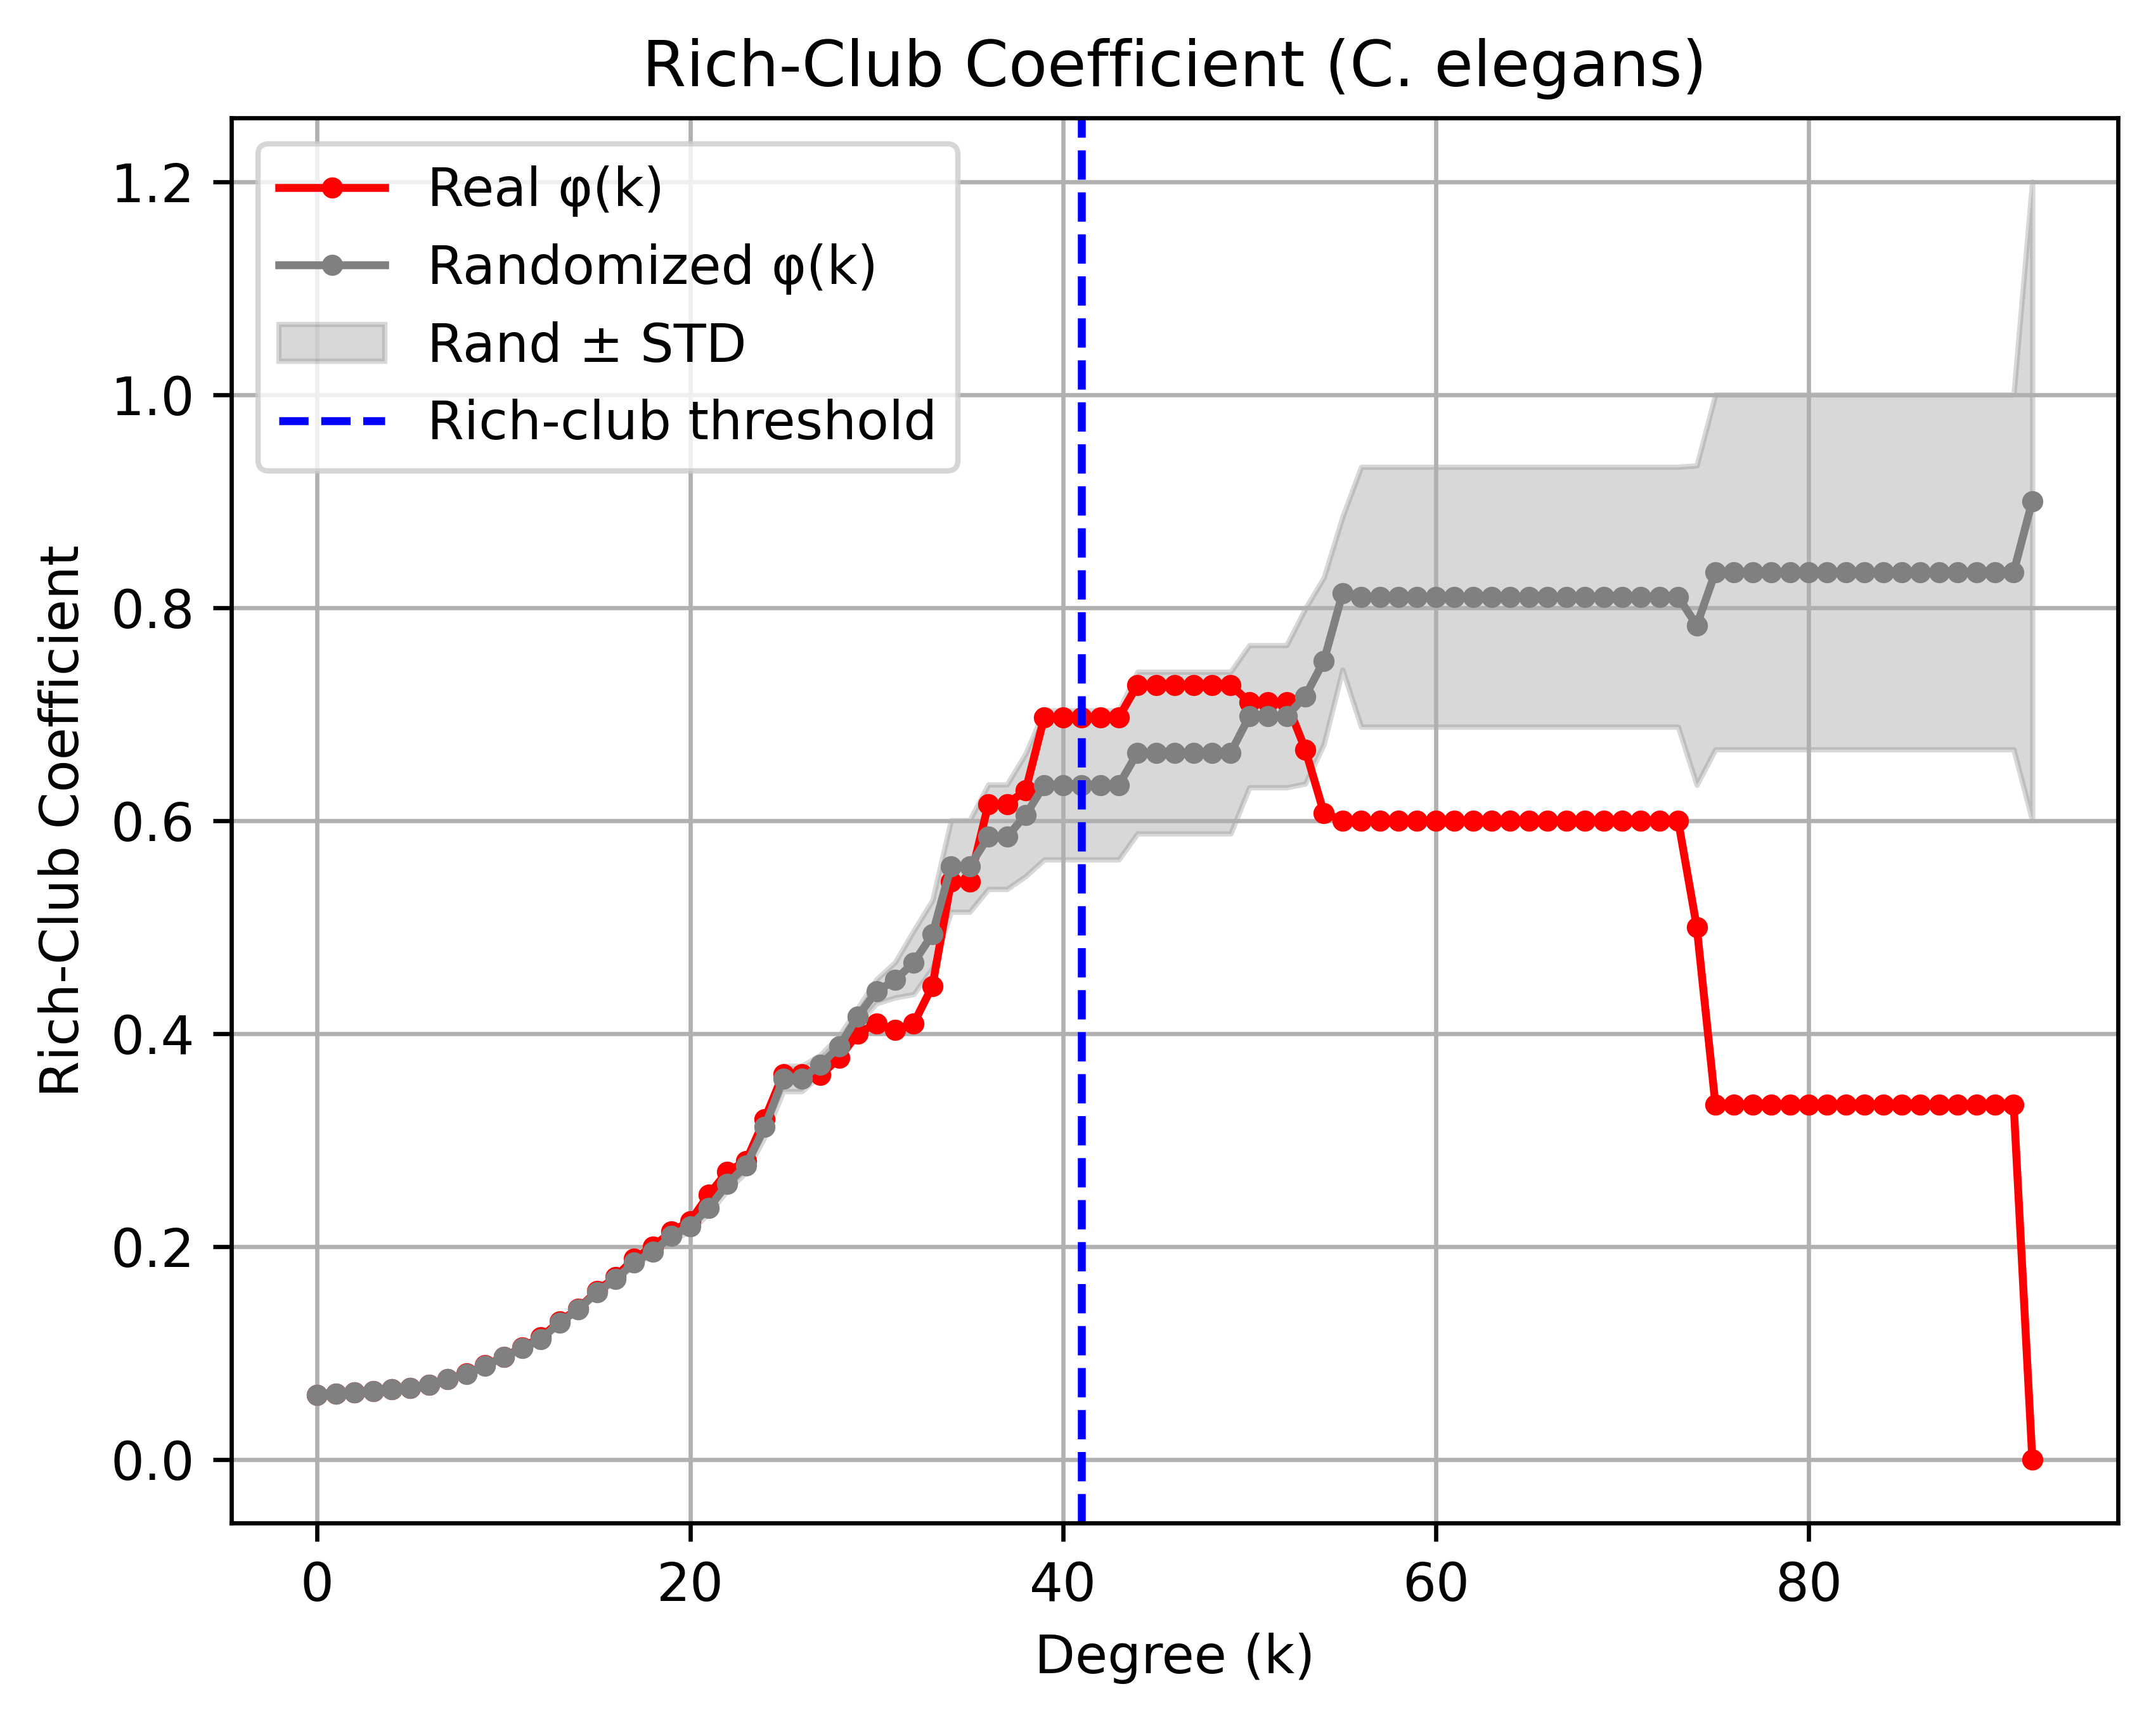

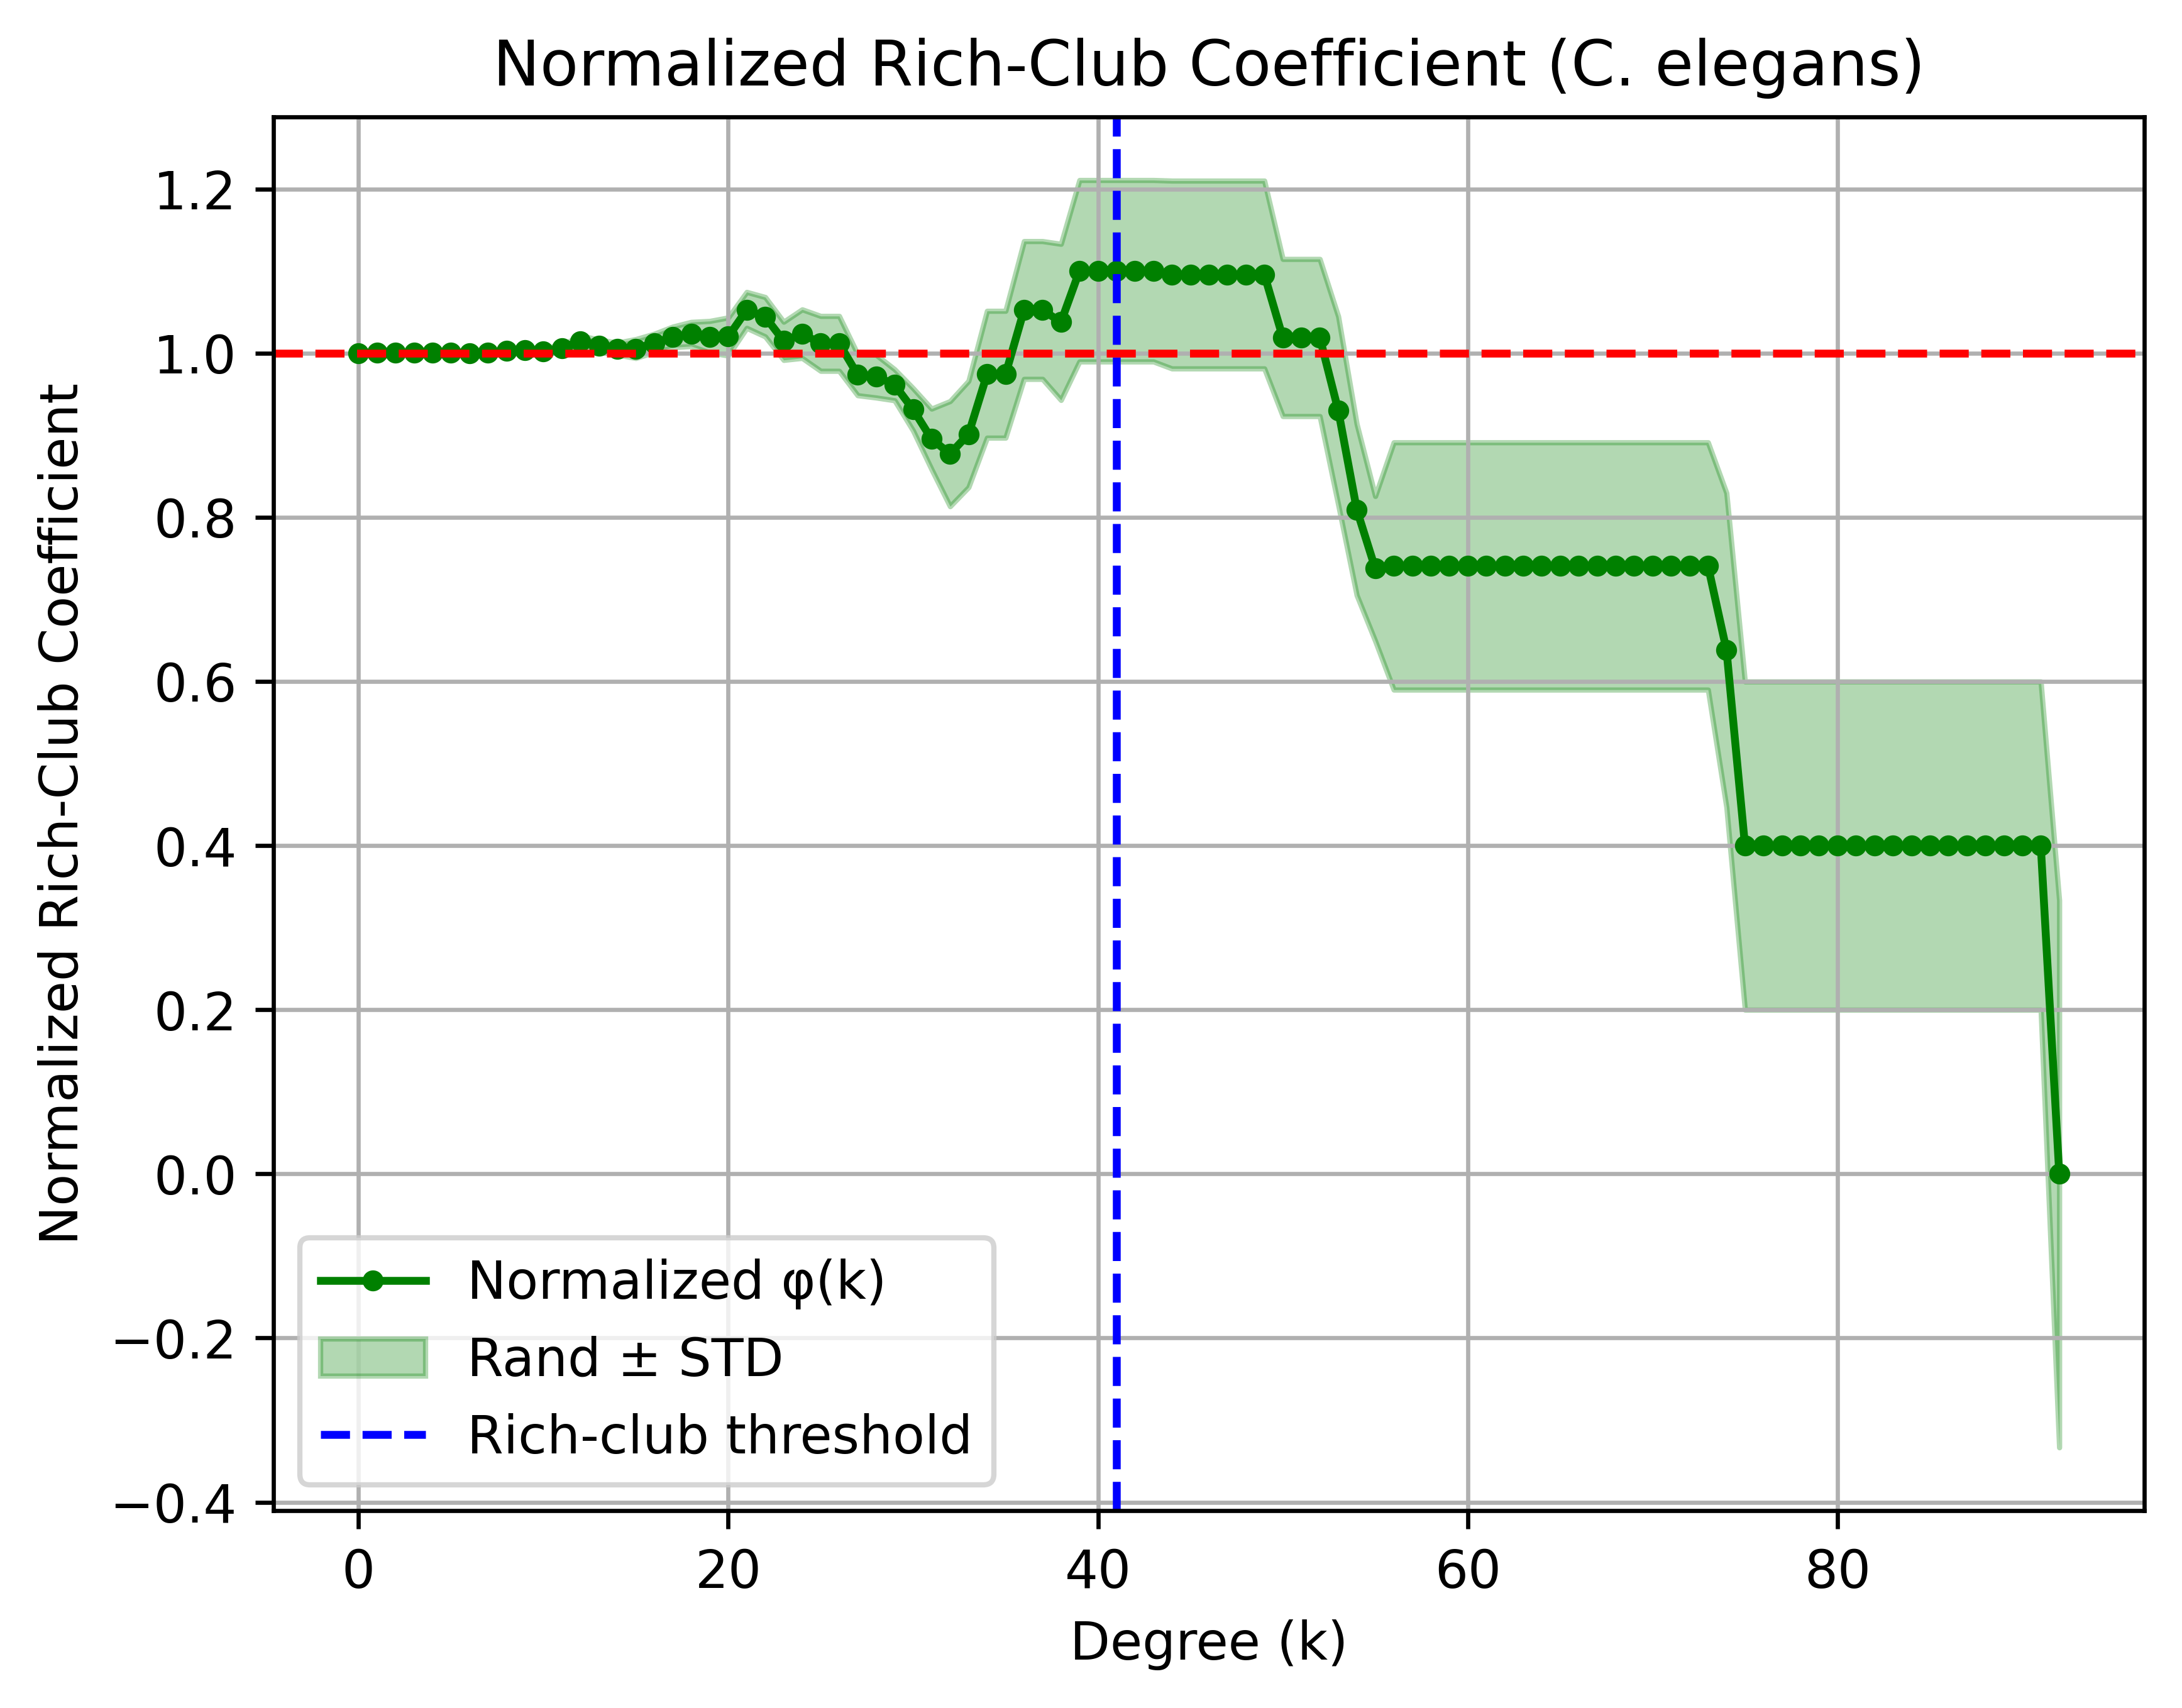

In [10]:
# ======== COMPUTE RICH-CLUB ========
rc_real, rc_rand_avg, rc_rand_std, rc_norm =  rich_club(G_dir, method="degree_preserving",n_rand=10)

# Convert to undirected and get degrees
G_und = G_dir.to_undirected()
degrees = dict(G_und.degree())


# ======== DETERMINE RICH-CLUB THRESHOLD ========
k_vals = list(rc_real.keys())
significant_k = [k for k in k_vals if rc_real[k] > rc_rand_avg[k] + rc_rand_std[k]]

if not significant_k:
    print("No significant rich-club degree found")
    k_rich = None
    rich_club_neurons = []
else:
    k_rich = 41 # This is the value from the paper............
    rich_club_neurons = [n for n, d in degrees.items() if d >= k_rich]
    print(f"Rich-club threshold degree: {k_rich}")
    print(f"Number of neurons in rich club: {len(rich_club_neurons)}")
    print("Rich-club neurons:", rich_club_neurons)

plot_rich_club(rc_real,rc_rand_avg,rc_rand_std,rc_norm,k_vals,k_rich)


# Let's see how computing the random reference netorks influence the rich club selection. 

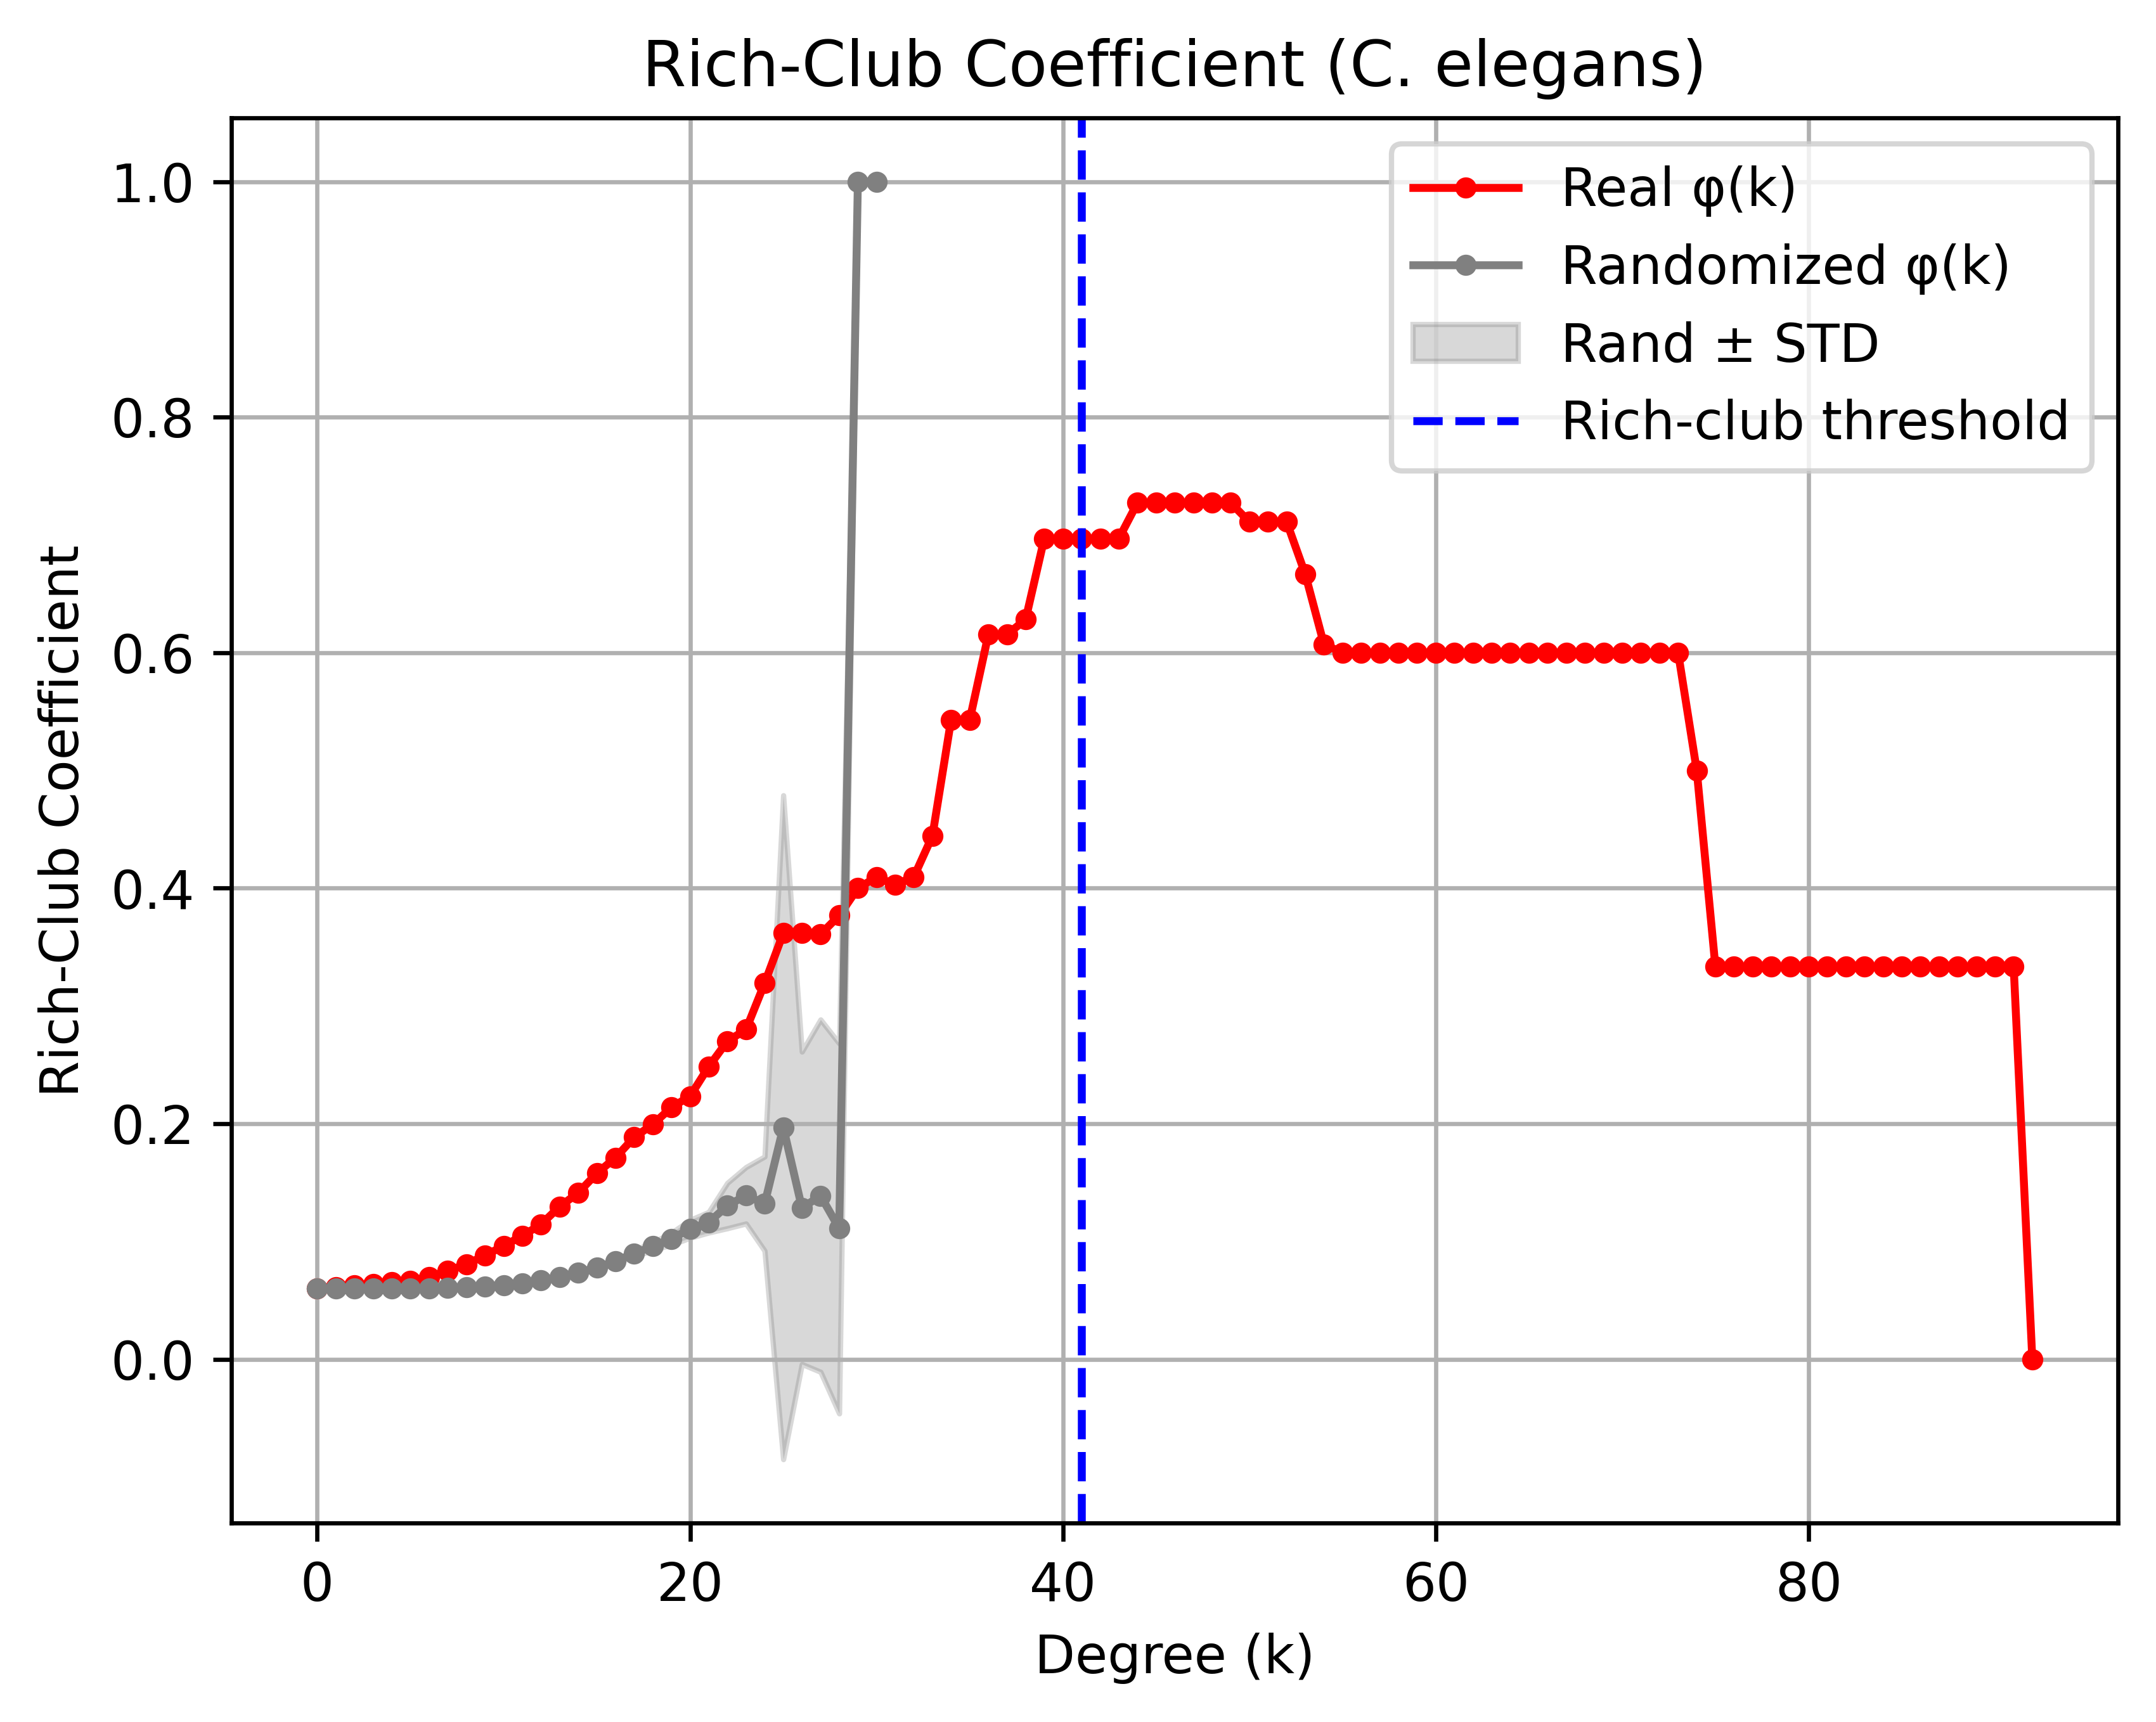

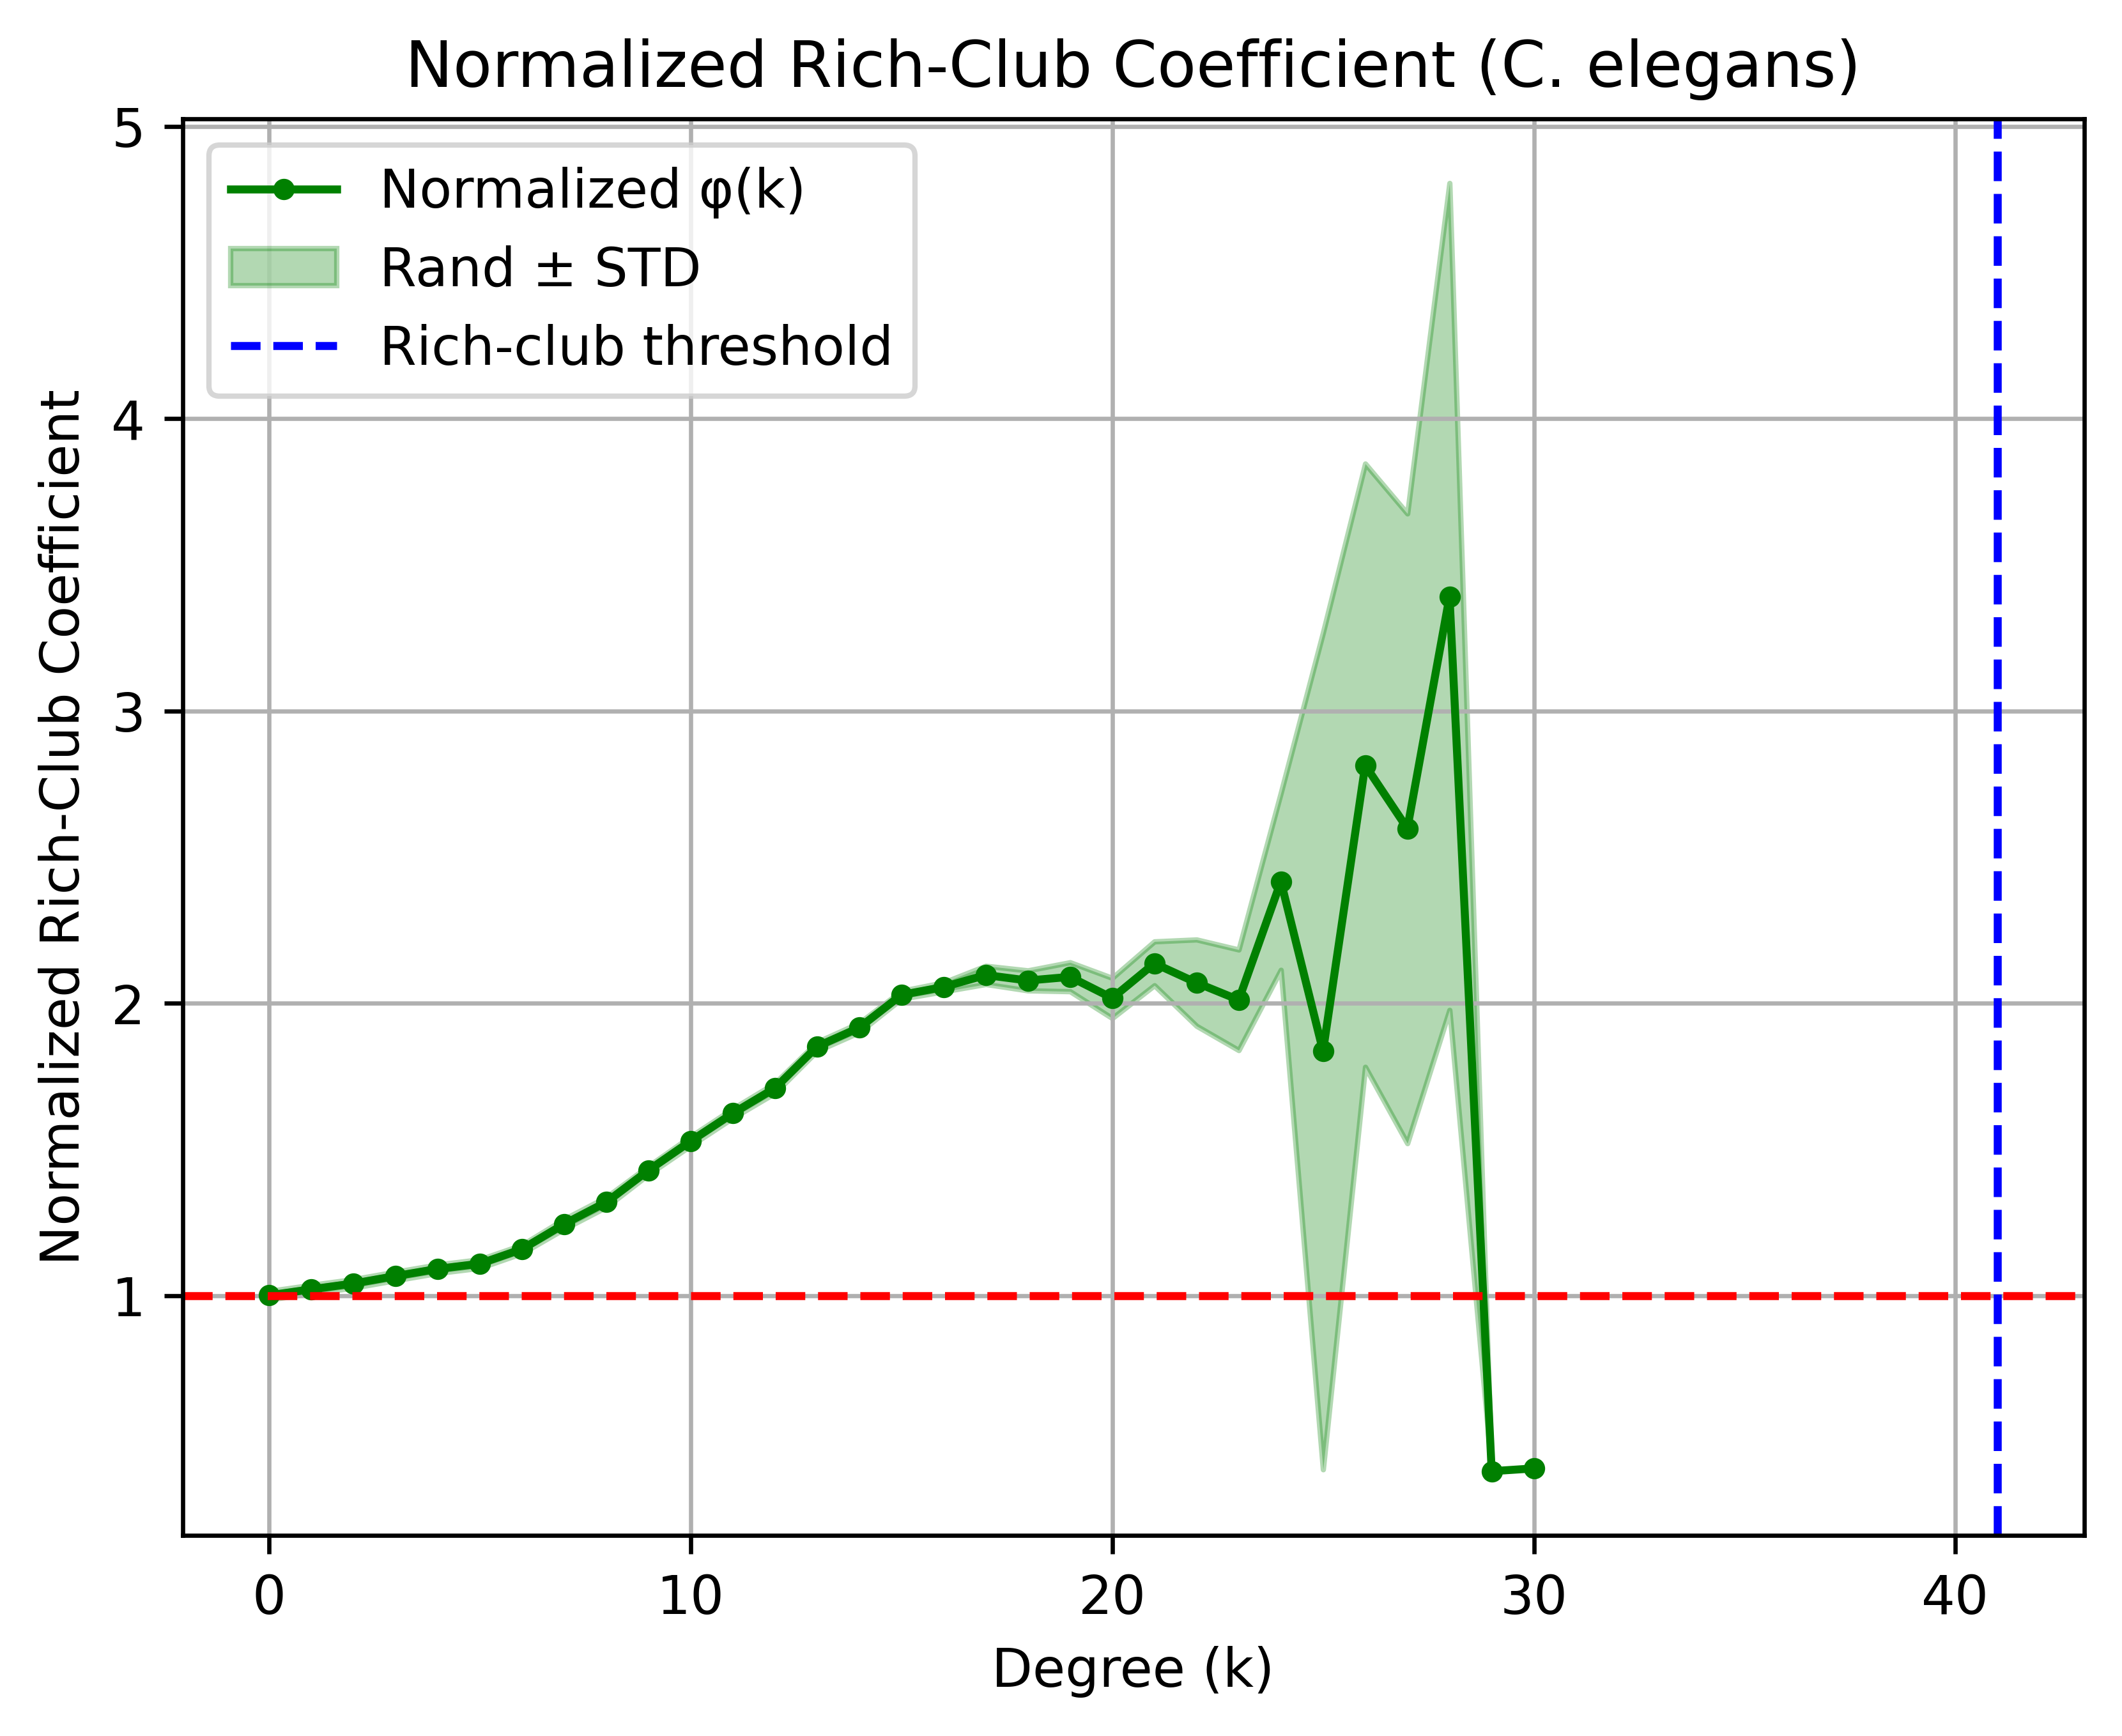

In [98]:
rc_real, rc_rand_avg, rc_rand_std, rc_norm = rich_club(G_dir, method="erdos_renyi",n_rand=10)
plot_rich_club(rc_real,rc_rand_avg,rc_rand_std,rc_norm,k_vals,k_rich)


## Let's see how these random networks diverge from the real ones: 
### We are calculating graph metrics for the real, the configuration-preserved randomized, and the Erdos-Renyi ntwrkx

E is  2291
E is  2291


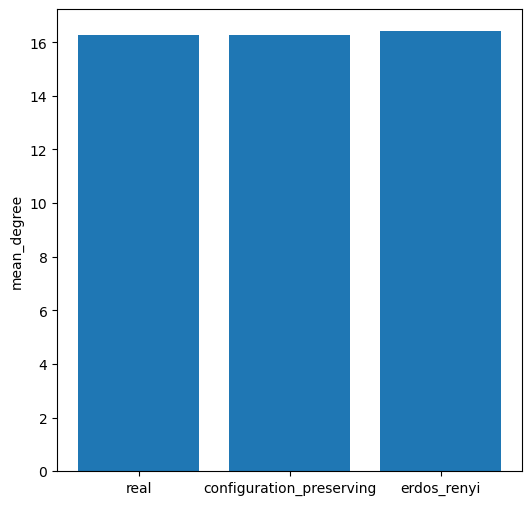

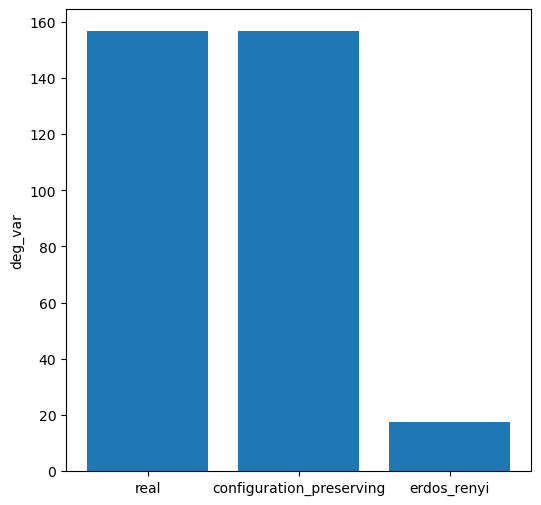

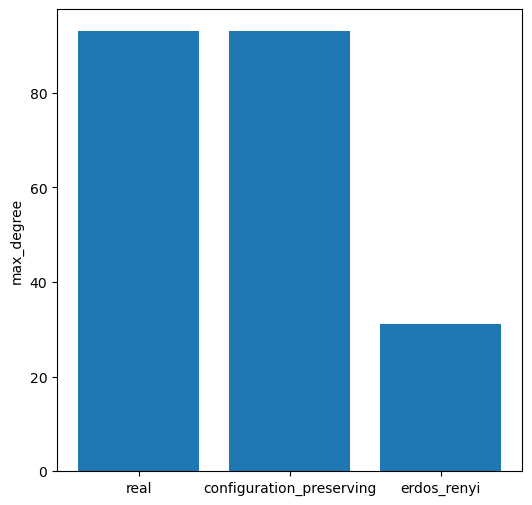

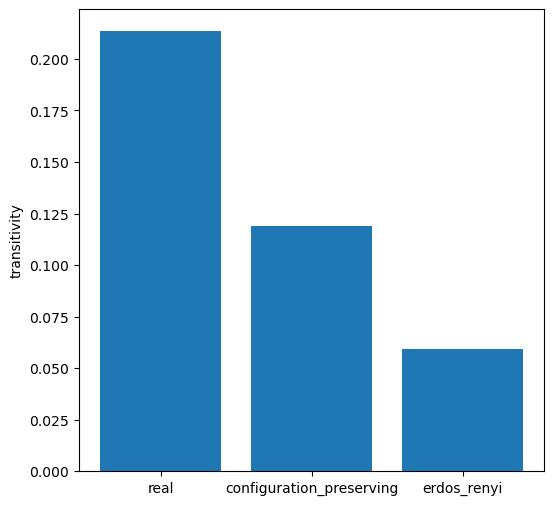

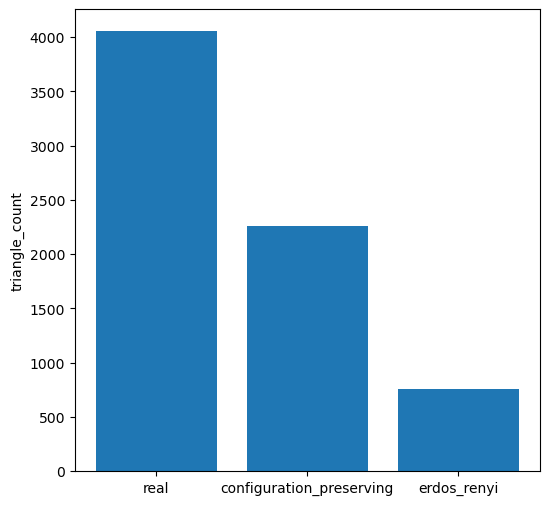

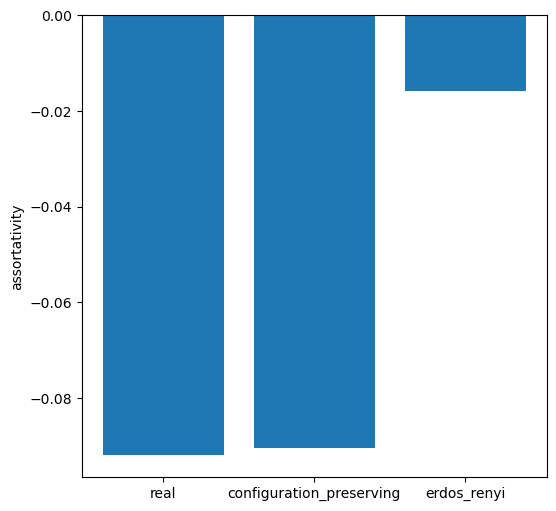

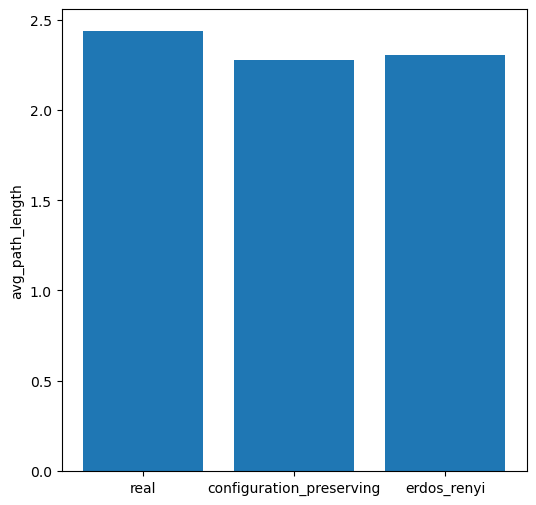

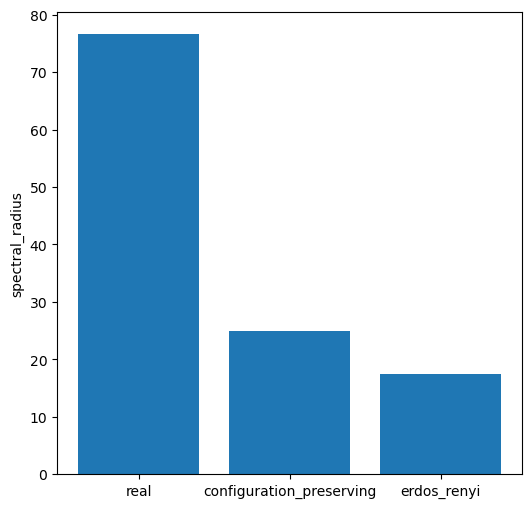

In [21]:
#Erdos-Renyi as the base of comparison ========================================

avg_degree_real = np.mean([d for n, d in G_und.degree()])
m_real = metric_set(G_und)


G_preserved = randomize_graph(G_und, method="degree_preserving")
avg_degree_preserved = np.mean([d for n, d in G_preserved.degree()])
m_preserved = metric_set(G_preserved)

G_er = randomize_graph(G_und, method="erdos_renyi")
avg_degree_er = np.mean([d for n, d in G_er.degree()])
m_er = metric_set(G_er)
labels = ['real','configuration_preserving', 'erdos_renyi']

for i in m_er.keys():
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_ylabel(i)
    ax.bar(range(3),[m_real[i],m_preserved[i],m_er[i]])
    ax.set_xticks(range(3))
    ax.set_xticklabels(labels)
    plt.show()


# Let us look at the connectivity statistics of the network 
* Betweeness
* Degree
* Nodal efficiency
* Participation

In [94]:
#BETWEENNESS 
G = G_und

degree_dict = dict(G.degree()) # puts all the degrees into a dict. 
betweenness = nx.betweenness_centrality(G, normalized=True)
print(betweenness['AIAL'])
print(betweenness['AVAL'])


0.003946778300846159
0.07932160027174372


## Participation coefficient

In [95]:
communities = list(community.greedy_modularity_communities(G))
modules = {}
for i, com in enumerate(communities):
    for node in com:
        modules[node] = i
participation = participation_coefficient(G, modules)
print(participation['AIAL'])
print(participation['AVAL'])


0.17233560090702937
0.4045368620037808


In [99]:
## Nodal efficiency

In [96]:
nodal_eff = nodal_efficiency(G)
print(nodal_eff['AIAL'])
print(nodal_eff['AVAL'])

0.44285714285714284
0.6529761904761905


In [100]:
## Determining Rich Club and Whole Network

In [103]:
# ======== RICH CLUB CLASSIFICATION ==========================================
#back up richclub from the paper:
richclub_nodes_paper = ['AVDR',
 'AVAR',
 'AVBL',
 'AVBR',
 'AVDL',
 'AVEL',
 'AVAL',
 'AVER',
 'PVCL',
 'DVA',
 'PVCR']

threshold = 44
richclub_nodes = [n for n, d in degree_dict.items() if d >= threshold]
labels = {n: ("Rich club" if n in richclub_nodes else "Periphery") for n in G.nodes()}

# ======== ASSEMBLE DATAFRAME =================================================
df = pd.DataFrame({
    "neuron": list(G.nodes()),
    "degree": [degree_dict[n] for n in G.nodes()],
    "betweenness": [betweenness[n] for n in G.nodes()],
    "nodal_eff": [nodal_eff[n] for n in G.nodes()],
    "participation": [participation[n] for n in G.nodes()],
    "group": [labels[n] for n in G.nodes()]
})

# Add "Whole network" group by duplicating rows
df_whole = df.copy()
df_whole["group"] = "Whole network"
df_all = pd.concat([df, df_whole], ignore_index=True)
print(df_all)


    neuron  degree  betweenness  nodal_eff  participation          group
0     ADAR      22     0.004496   0.509524       0.557851      Periphery
1     ADAL      25     0.008562   0.519048       0.636800      Periphery
2     ADFL      10     0.000461   0.413690       0.420000      Periphery
3     ASHL      20     0.003808   0.497619       0.655000      Periphery
4     AVDR      55     0.019962   0.573214       0.362314      Rich club
..     ...     ...          ...        ...            ...            ...
561   PLNL       3     0.000075   0.412202       0.666667  Whole network
562   PLNR       2     0.000000   0.344643       0.000000  Whole network
563   VD07       8     0.000107   0.426786       0.000000  Whole network
564    NMJ     115     0.182526   0.686310       0.470473  Whole network
565   VC06       1     0.000000   0.394048       0.000000  Whole network

[566 rows x 6 columns]


## Plotting the coefficients for:
* Rich club
* periphery 
* whole network 

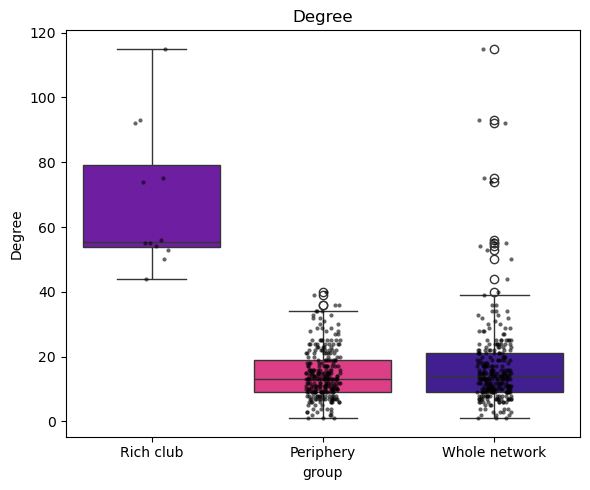

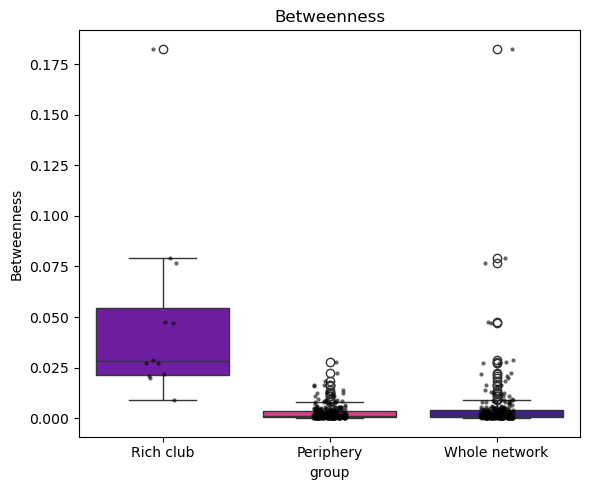

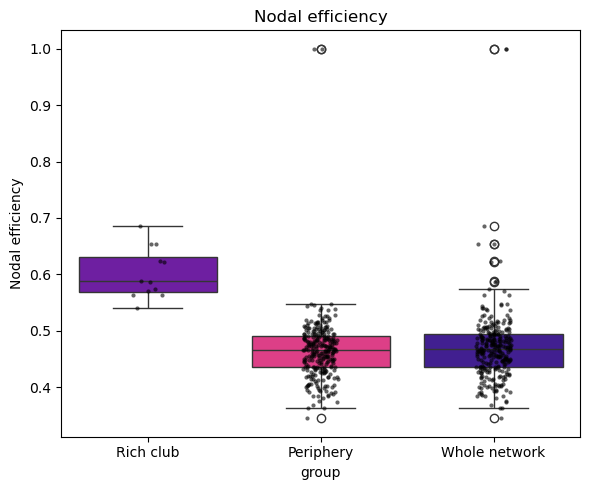

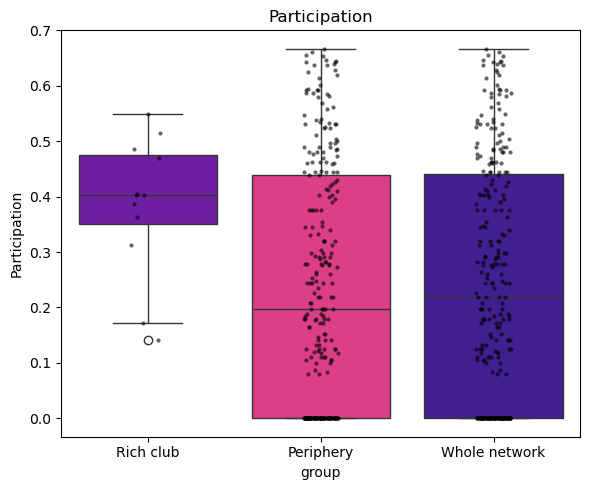

In [110]:
# ======== PLOTS ==============================================================
metrics = ["degree", "betweenness", "nodal_eff", "participation"]
labels = ["Degree","Betweenness", "Nodal efficiency", "Participation"]

for m,l in zip(metrics,labels):
    plt.figure(figsize=(6,5))
    sns.boxplot(
        data=df_all,
        x="group", y=m,
        hue="group",
        order=["Rich club", "Periphery", "Whole network"],
        palette=["#F72585", "#7209B7", "#3A0CA3"], #["red", "blue", "gray"],
        legend=False
        )
    sns.stripplot(data=df_all, x="group", y=m, order=["Rich club","Periphery","Whole network"],
                  color="k", size=3, jitter=True, alpha=0.6)
    plt.ylabel(l)
    plt.title(l)
    plt.tight_layout()
    plt.show()